In [1]:
!pip install statsmodels matplotlib seaborn pygam numpy==1.24.4 pandas==2.2.2


In [19]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from pygam import LinearGAM, s

In [4]:
# Load the dataset
file_path = "/content/EMOSS_edited.xlsx"
df = pd.read_excel(file_path)

# Count missing values for all columns
missing_values = df.isnull().sum()

# Filter only columns with missing values
missing_values = missing_values[missing_values > 0]

# Sort by highest missing values
missing_values = missing_values.sort_values(ascending=False)

# Display the first 60 result
print(missing_values[1:60])

print(df.columns.tolist())

# Define columns where we want to drop missing values
columns_to_drop_na = ["PWV Avg.", "Gender", "ESS Score",'PSQI1', 'PSQI2', 'PSQI3', 'PSQI4', 'PSQI5a',
                      'PSQI5b', 'PSQI5c', 'PSQI5d', 'PSQI5e', 'PSQI5f', 'PSQI5g', 'PSQI5h', 'PSQI5i', 'PSQI5j', 'PSQI6', 'PSQI7',
                      'PSQI8', 'PSQI9']


# Assign missing values in PSQI5j to 1
df["PSQI5j"] = df["PSQI5j"].fillna(1)


# Drop rows with missing values in the selected columns
df = df.dropna(subset=columns_to_drop_na)

df.info()

"""**Now, we have a better data with 8 entries and 199  cleaned columns. Let us check if the "PSQI2", "PSQI4", "PSQI5a", "PSQI5b", "PSQI5c", "PSQI5d", "PSQI5e", "PSQI5f", "PSQI5g", "PSQI5h",... columns still exist.**"""

print(df.columns.tolist())

"""**So, among all the PSQI columns, only PSQI5j was removed due to it excessive missing values (50% missing!) which might affect the analysis.**"""

# Rescale PSQI items (1-4 to 0-3)
psqi_columns = ["PSQI2", "PSQI4", "PSQI5a", "PSQI5b", "PSQI5c", "PSQI5d", "PSQI5e", "PSQI5f", "PSQI5g", "PSQI5h", "PSQI5i","PSQI6", "PSQI7", "PSQI8", "PSQI9"]
df[psqi_columns] = df[psqi_columns] - 1

# Compute PSQI components
psqi_components = pd.DataFrame()
psqi_components['C1'] = df['PSQI9']
psqi_components['C2'] = (df['PSQI2'] + df['PSQI5a']).apply(lambda x: 0 if x == 0 else (1 if x <= 2 else (2 if x <= 4 else 3)))
psqi_components['C3'] = df['PSQI4'].apply(lambda x: 0 if x > 7 else (1 if x >= 6 else (2 if x >= 5 else 3)))
psqi_components['C4'] = (df['PSQI3'] * 100).apply(lambda x: 0 if x > 85 else (1 if x >= 75 else (2 if x >= 65 else 3)))
psqi_components['C5'] = df[["PSQI5b", "PSQI5c", "PSQI5d", "PSQI5e", "PSQI5f", "PSQI5g", "PSQI5h", "PSQI5i"]].sum(axis=1)
psqi_components['C5'] = psqi_components['C5'].apply(lambda x: 0 if x == 0 else (1 if x <= 9 else (2 if x <= 18 else 3)))
psqi_components['C6'] = df['PSQI6']
psqi_components['C7'] = (df['PSQI7'] + df['PSQI8']).apply(lambda x: 0 if x == 0 else (1 if x <= 2 else (2 if x <= 4 else 3)))

# Concatenate computed PSQI components back into df
df = pd.concat([df, psqi_components], axis=1)

# Compute Global PSQI Score
df['PSQI_Score'] = df[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']].sum(axis=1)
print(df[['PSQI_Score']].head())

# Classify Sleep Quality
df['Sleep Quality'] = df['PSQI_Score'].apply(lambda x: 'Poor_Sleeper' if x >= 5 else 'Good_Sleeper')

# Rename necessary columns to match the variable names
df = df.rename(columns={
    'PWV Avg.': 'PWV_Avg',
    'ESS Score': 'ESS_Score',
    'Race/Ethnicity': 'Race'
})

MOSSQ4b                                67
PSQI5j                                 62
PSQI10e                                60
Medical history                        59
MOSSQ3b                                56
MOSSQ4a                                53
MOSSQ4c                                53
MOSSQ2b                                45
MOSSQ3c                                42
PWV Measurement 2                      40
MOSSQ3a                                39
MOSSQ1b (months)                       32
MOSSQtwice c                           31
MOSSQ2a                                29
PSQI10b                                29
PWV Measurement 1                      26
PSQI10c                                26
PWV Avg.                               26
PSQI10a                                25
PSQI10d                                20
MOSSQoncec (x per day)                 19
MOSSQ1a                                16
Usual Sleep Time                       11
Average nightly diastolic         

In [5]:
# Clean Racial Groups
df['Race_Grouped'] = df['Race'].replace({
    'White': 'White',
    'Caucasian': 'White',
    'African American': 'Black',
    'Black or African American': 'Black',
    'Asian': 'Asian',
    'Asian/Pacific Islander': 'Asian',
    'Hispanic/Latino': 'Hispanic',
    'Middle Eastern': 'Other',
    'Other': 'Other'
})

In [6]:
# Summary statistics
summary_stats = {
    "BMI_mean": df["BMI"].mean(),
    "BMI_std": df["BMI"].std(),
    "AHI_mean": df["AHI"].mean(),
    "AHI_std": df["AHI"].std(),
    "ESS_mean": df["ESS_Score"].mean(),
    "ESS_std": df["ESS_Score"].std(),
    "PSQI_mean": df["PSQI_Score"].mean(),
    "PSQI_std": df["PSQI_Score"].std()
}

print(summary_stats)

{'BMI_mean': 33.828571428571415, 'BMI_std': 7.740601555589611, 'AHI_mean': 28.895238095238085, 'AHI_std': 21.382962984366394, 'ESS_mean': 10.015873015873016, 'ESS_std': 5.113208901847989, 'PSQI_mean': 21.056472380952385, 'PSQI_std': 2.9347072981181803}


In [7]:
# Calculate mean and standard deviation for Age
mean_age = df['Age'].mean()
std_age = df['Age'].std()
print(f"Mean Age: {mean_age:.2f}")
print(f"Standard Deviation of Age: {std_age:.2f}")

# Calculate percentage of male and female participants
gender_counts = df['Gender'].value_counts(normalize=True) * 100
percent_male = gender_counts.get('M', 0)  # Assuming 'M' for male
percent_female = gender_counts.get('F', 0)  # Assuming 'F' for female
print(f"Percentage Male: {percent_male:.2f}%")
print(f"Percentage Female: {percent_female:.2f}%")

# Summarize race data
race_counts = df['Race_Grouped'].value_counts(normalize=True) * 100
print("\nRace Distribution (%):")
print(race_counts.round(2))

Mean Age: 51.33
Standard Deviation of Age: 13.80
Percentage Male: 57.14%
Percentage Female: 42.86%

Race Distribution (%):
Race_Grouped
Black       49.21
White       41.27
Hispanic     4.76
Asian        3.17
Other        1.59
Name: proportion, dtype: float64


In [8]:
# Define variables for regression analysis
ccl5_col = 'CCL5'
pwv_col = 'PWV_Avg'
ess_col = 'ESS_Score'
age_col = 'Age'
sex_col = 'Gender'
bmi_col = 'BMI'
race_col = 'Race_Grouped'
ahi_col = 'AHI'
psqi_col = 'PSQI_Score'

In [9]:
# Mean-centering to Reduce Multicolinearility
df[ccl5_col] = df[ccl5_col] - df[ccl5_col].mean()
df[age_col] = df[age_col] - df[age_col].mean()
df[bmi_col] = df[bmi_col] - df[bmi_col].mean()
df[ahi_col] = df[ahi_col] - df[ahi_col].mean()


In [10]:
# Check VIF Value
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[[ccl5_col, age_col, bmi_col, ahi_col]].copy()
X = X.assign(sex=pd.Categorical(df[sex_col]).codes, race=pd.Categorical(df[race_col]).codes)

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


  Variable       VIF
0     CCL5  1.019250
1      Age  1.101368
2      BMI  1.196355
3      AHI  1.114211
4      sex  1.941790
5     race  1.817803


In [11]:
# Linear Regression model: CCL5 and PWV
formula = f'{pwv_col} ~ {ccl5_col} + {age_col} + C({sex_col}) + {bmi_col}+ C({race_col}) + {ahi_col} '

model_full = smf.ols(formula, data=df).fit()

print("Full Sample Regression Results:")

print(model_full.summary())

Full Sample Regression Results:
                            OLS Regression Results                            
Dep. Variable:                PWV_Avg   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     1.405
Date:                Wed, 30 Apr 2025   Prob (F-statistic):              0.210
Time:                        16:00:08   Log-Likelihood:                -135.70
No. Observations:                  63   AIC:                             291.4
Df Residuals:                      53   BIC:                             312.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [21]:
import scipy.sparse as sp_sparse

# Monkey‐patch csr_matrix so it has an .A attribute
sp_sparse.csr_matrix.A = property(lambda self: self.toarray())

In [30]:
# Generalized Additive Model: CCL5 and PWV based on ESS Score
X = df[[ccl5_col, age_col, bmi_col, ahi_col]].values.astype(float)
y = df[pwv_col].values.astype(float)

gam = LinearGAM(s(0) + s(1) + s(2) + s(3)).fit(X, y)
gam.summary()


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     21.8074
Link Function:                     IdentityLink Log Likelihood:                                  -162.9746
Number of Samples:                           63 AIC:                                               371.564
                                                AICc:                                             399.2726
                                                GCV:                                               12.2176
                                                Scale:                                              4.9634
                                                Pseudo R-Squared:                                   0.3976
Feature Function                  Lam

<ipython-input-30-aa3afc6f584d>:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [23]:
# Stratify participants into sleepy and non-sleepy groups based on ESS Score
sleepy_threshold = 10
df['ESS_Sleepy_Group'] = df[ess_col].apply(lambda x: 'Sleepy' if x >= sleepy_threshold else 'Non-Sleepy')

In [24]:
# Stratified Analysis: Sleepy vs. Non-Sleepy based on ESS Score
for group in df['ESS_Sleepy_Group'].unique():
    subset = df[df['ESS_Sleepy_Group'] == group]
    model = smf.ols(formula, data=subset).fit()
    print(f"Regression Results for {group} Group:")
    print(model.summary())

Regression Results for Sleepy Group:
                            OLS Regression Results                            
Dep. Variable:                PWV_Avg   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                 -0.068
Method:                 Least Squares   F-statistic:                    0.7457
Date:                Wed, 30 Apr 2025   Prob (F-statistic):              0.652
Time:                        16:17:14   Log-Likelihood:                -75.389
No. Observations:                  33   AIC:                             168.8
Df Residuals:                      24   BIC:                             182.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

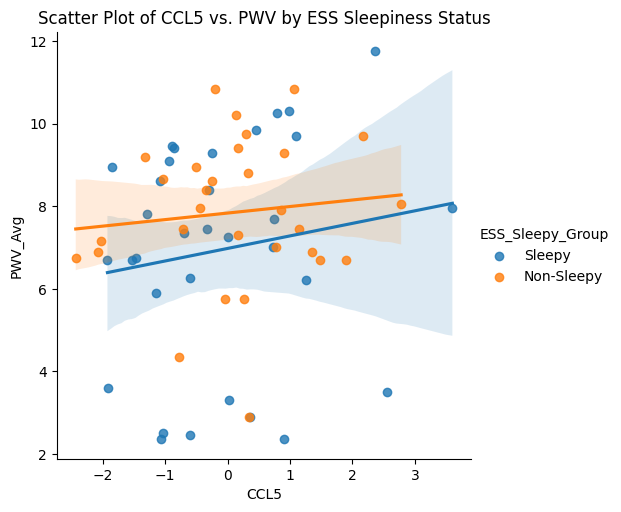

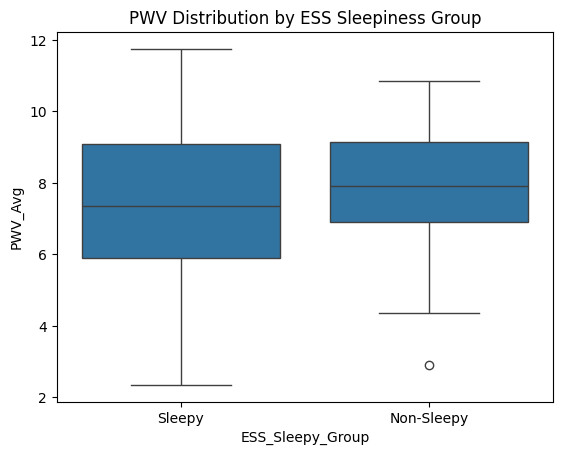

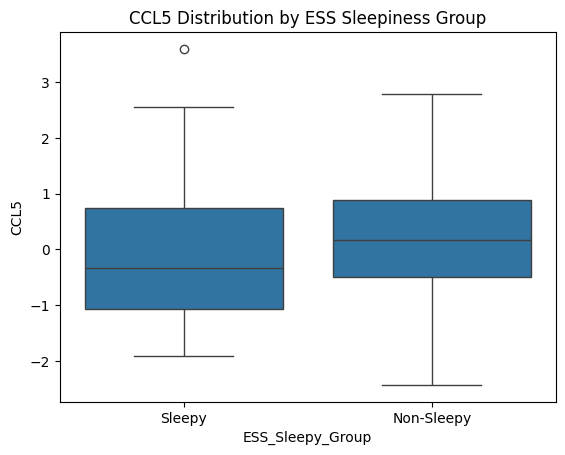

In [25]:
# Visualizations
sns.lmplot(x=ccl5_col, y=pwv_col, hue='ESS_Sleepy_Group', data=df)
plt.title('Scatter Plot of CCL5 vs. PWV by ESS Sleepiness Status')
plt.show()

sns.boxplot(x='ESS_Sleepy_Group', y=pwv_col, data=df)
plt.title('PWV Distribution by ESS Sleepiness Group')
plt.show()

sns.boxplot(x='ESS_Sleepy_Group', y=ccl5_col, data=df)
plt.title('CCL5 Distribution by ESS Sleepiness Group')
plt.show()

In [31]:
# Define predictors for GAM
predictors = [ccl5_col, age_col, bmi_col, ahi_col]

# Stratified GAM analysis for Sleepy vs. Non-Sleepy groups
for group in df['ESS_Sleepy_Group'].unique():
    subset = df[df['ESS_Sleepy_Group'] == group]

    # Fit GAM model with smooth terms for continuous predictors
    gam = LinearGAM(s(0) + s(1) + s(2) + s(3)).fit(subset[predictors], subset[pwv_col])

    print(f"\nGAM Results for {group} Group:")
    print(gam.summary())


GAM Results for Sleepy Group:
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                       5.062
Link Function:                     IdentityLink Log Likelihood:                                   -99.0973
Number of Samples:                           33 AIC:                                              210.3186
                                                AICc:                                             213.6195
                                                GCV:                                               10.4365
                                                Scale:                                              7.6013
                                                Pseudo R-Squared:                                   0.0873
Featur

<ipython-input-31-2925e132574d>:12: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())
<ipython-input-31-2925e132574d>:12: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


In [27]:
# Stratify participants into sleepy and non-sleepy groups based on PSQI Score
PSQI_threshold = 5
df['PSQI_Sleepy_Group'] = df[ess_col].apply(lambda x: 'Sleepy' if x >= sleepy_threshold else 'Non-Sleepy')

# Stratified Analysis: Sleepy vs. Non-Sleepy based on PSQI Score
for group in df['PSQI_Sleepy_Group'].unique():
    subset = df[df['PSQI_Sleepy_Group'] == group]
    model = smf.ols(formula, data=subset).fit()
    print(f"Regression Results for {group} Group:")
    print(model.summary())

Regression Results for Sleepy Group:
                            OLS Regression Results                            
Dep. Variable:                PWV_Avg   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                 -0.068
Method:                 Least Squares   F-statistic:                    0.7457
Date:                Wed, 30 Apr 2025   Prob (F-statistic):              0.652
Time:                        16:17:34   Log-Likelihood:                -75.389
No. Observations:                  33   AIC:                             168.8
Df Residuals:                      24   BIC:                             182.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

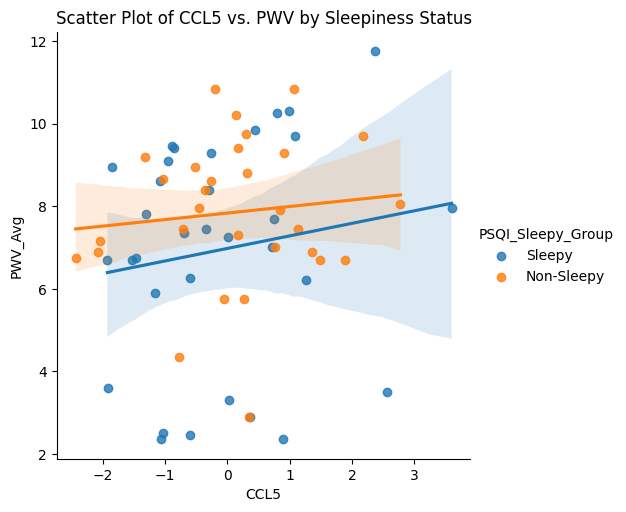

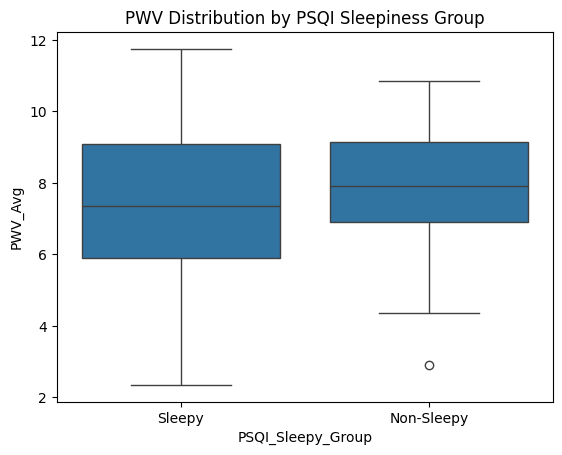

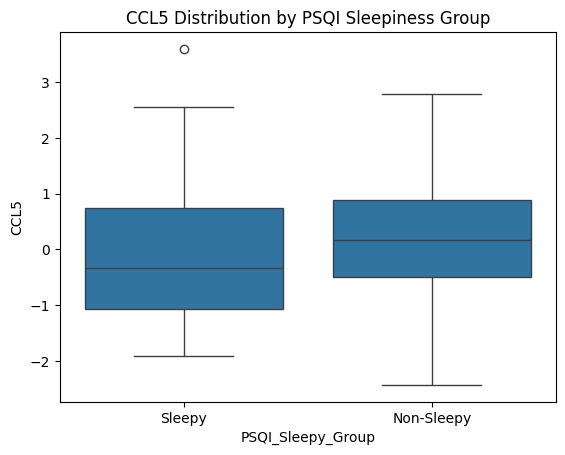

In [28]:
# Visualizations
sns.lmplot(x=ccl5_col, y=pwv_col, hue='PSQI_Sleepy_Group', data=df)
plt.title('Scatter Plot of CCL5 vs. PWV by Sleepiness Status')
plt.show()

sns.boxplot(x='PSQI_Sleepy_Group', y=pwv_col, data=df)
plt.title('PWV Distribution by PSQI Sleepiness Group')
plt.show()

sns.boxplot(x='PSQI_Sleepy_Group', y=ccl5_col, data=df)
plt.title('CCL5 Distribution by PSQI Sleepiness Group')
plt.show()

In [29]:
# Stratified GAM analysis for Sleepy vs. Non-Sleepy groups based on PSQI Score
for group in df['PSQI_Sleepy_Group'].unique():
    subset = df[df['PSQI_Sleepy_Group'] == group]

    # Fit GAM model with smooth terms for continuous predictors
    gam = LinearGAM(s(0) + s(1) + s(2) + s(3)).fit(subset[predictors], subset[pwv_col])

    print(f"\nGAM Results for {group} Group:")
    print(gam.summary())



GAM Results for Sleepy Group:
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                       5.062
Link Function:                     IdentityLink Log Likelihood:                                   -99.0973
Number of Samples:                           33 AIC:                                              210.3186
                                                AICc:                                             213.6195
                                                GCV:                                               10.4365
                                                Scale:                                              7.6013
                                                Pseudo R-Squared:                                   0.0873
Featur

<ipython-input-29-e8747b77b45d>:9: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())
<ipython-input-29-e8747b77b45d>:9: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


In [ ]:
# Save processed data
output_file = "processed_EMOSS_data.csv"
df.to_csv(output_file, index=False)
print(f"Processed data saved as {output_file}")